In [1]:
import importlib
import model.Portfolio as Portfolio

# importlib.reload(Portfolio)

In [2]:
names = ["VUSA", "A35", "S59", "VUSD", "BAB", "IWDA", "Z74", "ES3", "VWRD"]
p = Portfolio.Portfolio()

# Add all assets
for name in names:
    p.addAsset(f"data/{name}.csv", name)

# Convert non SGD assets to SGD
p.addExchangeRate("data/forex/SGDEUR.csv", "EUR", True)
p.addExchangeRate("data/forex/USDSGD.csv", "USD", False)
p.exchangeAdjustment(0, "EUR")
p.exchangeAdjustment(3, "USD")
p.exchangeAdjustment(4, "USD")
p.exchangeAdjustment(5, "USD")
p.exchangeAdjustment(8, "USD")

In [3]:
currentWeight = [
    0.08992020522,
    0.2744348384,
    0.03070927321,
    0.01896821775,
    0.06166520726,
    0.06204753154,
    0.02053451402,
    0.3393806347,
    0.102339578,
]

p.portfolioPerformance(currentWeight)

{'returns': 0.046602380697228225,
 'variance': 0.004724437320510276,
 'sharpe': 9.864112387503281}

In [4]:
def randomWeight(length):
    w = np.random.random(length)
    w /= np.sum(w)
    return w

In [110]:
%%time

noSimulations = 100000
rf = 0.02
simWeights = []
simRets = []
simVols = []
simSharpes = []

for i in range(noSimulations):
    weights = randomWeight(len(names))
    perf = p.portfolioPerformance(weights, rf=rf)

    simWeights.append(weights)
    simRets.append(perf["returns"])
    simVols.append(perf["variance"])
    simSharpes.append(perf["sharpe"])

CPU times: user 5min 58s, sys: 34.3 ms, total: 5min 58s
Wall time: 5min 58s


<IPython.core.display.Javascript object>

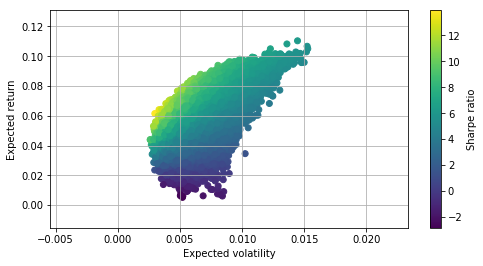

<IPython.core.display.Javascript object>

In [111]:
plt.figure(figsize=(8, 4))
plt.scatter(simVols, simRets, c=simSharpes, marker="o")
plt.grid(True)
plt.xlabel("Expected volatility")
plt.ylabel("Expected return")
plt.colorbar(label="Sharpe ratio")
plt.show()

In [113]:
# Get top 10 portfolio with highest sharpe
sortedIndices = np.argsort(simSharpes)[-10:]

results = []
for x in sortedIndices:
    results.append(np.insert(simWeights[x], 0, [simSharpes[x], simRets[x], simVols[x]]))
pd.DataFrame(results, columns=["SharpeRatio", "Returns", "Volatility"] + stockNames)

,SharpeRatio,Returns,Volatility,VUSA,A35,S59,VUSD,BAB,IWDA,Z74,ES3,VWRD
0,12.040879,0.063957,0.003651,0.065165,0.275278,0.015617,0.052115,0.293299,0.174236,0.064450,0.032448,0.027392
1,12.045242,0.070661,0.004206,0.123103,0.220366,0.005790,0.077446,0.265038,0.175980,0.021015,0.107689,0.003573
2,12.049978,0.062572,0.003533,0.113238,0.133509,0.038796,0.059523,0.379202,0.006535,0.059160,0.083219,0.126817
3,12.064473,0.067218,0.003914,0.020578,0.147586,0.011000,0.109573,0.340300,0.139900,0.061003,0.146885,0.023175
4,12.188508,0.070059,0.004107,0.189421,0.179863,0.031988,0.129824,0.324589,0.024176,0.004584,0.074458,0.041097
5,12.253025,0.059887,0.003255,0.070982,0.288634,0.009459,0.032516,0.294034,0.134014,0.019313,0.112354,0.038694
6,12.489221,0.068189,0.003858,0.129314,0.182314,0.009542,0.045424,0.339761,0.076791,0.028687,0.083789,0.104377
7,12.565380,0.064412,0.003534,0.115276,0.144250,0.005903,0.010866,0.357837,0.079920,0.004369,0.192343,0.089236
8,13.306465,0.064101,0.003314,0.073356,0.278867,0.011554,0.010565,0.408995,0.159676,0.008277,0.016693,0.032017
9,13.940076,0.061485,0.002976,0.183456,0.190181,0.025982,0.038486,0.420990,0.001670,0.071329,0.030810,0.037096


<IPython.core.display.Javascript object>

In [35]:
import scipy.optimize as sco
import numpy as np

# Caution: Do not use this optimiser yet... it over optimises...
class Optimizer:
    def __init__(self, portfolio):
        self.portfolio = portfolio

    def optimize(self):
        numberOfAssets = len(self.portfolio.assetNames)
        constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
        bounds = tuple((0, 1) for x in range(numberOfAssets))
        initial = np.array(numberOfAssets * [1.0 / numberOfAssets])
        options = sco.minimize(
            lambda x: -self.portfolio.portfolioPerformance(x, rf=0.02)["sharpe"],
            initial,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
        )
        print(options)
        return options["x"]

In [38]:
%%time
o = Optimizer(p)
optimiserWeight = o.optimize()

     fun: -15.608382157192073
     jac: array([ 8.81454551,  8.8084259 , 29.84082437,  9.70446348,  8.81177592,
        8.8170352 ,  8.81780028,  8.81234694, 17.69694054])
 message: 'Optimization terminated successfully.'
    nfev: 163
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([0.17736687, 0.16119345, 0.        , 0.        , 0.51353228,
       0.05219099, 0.01816625, 0.07755016, 0.        ])
CPU times: user 506 ms, sys: 0 ns, total: 506 ms
Wall time: 505 ms


In [37]:
p.portfolioPerformance(optimiserWeight)

{'returns': 0.06593249084552458,
 'variance': 0.0029428092151344253,
 'sharpe': 22.40460934621371}

## Next Step

- Timeseries K-fold validation when generating weights
    - Monte carlo on K-1 segments of data
    - Test result on 1 segment of data
- Genetics algorithm
- Add backtest capabilities
    - Report over the entire period
    - Custom period

## Even More Advanced Shits

- Selective optimisation for time period (ie interest rate hike, financial crisis, etc)